# LLMs Translation Pipeline


This would be a pipeline for Machine Translation from lux to english including data pre-processing, translation and data post-processing.

1. Context information should be included inside each transation sample and sliding windows will be used.
2. Make full use of the model's hallucination properties to make more samples. (Different temperatures: 0.1,0.5,0.9,1.3)
3. Clean the models' output and check the correcteness of the models' output. (Corprus Checking)

In [ ]:
# Required packages
!pip install pandas transformers tqdm matplotlib torch bitsandbytes
!pip install fasttext langid
!apt install g++
!pip install spacy
!python -m spacy download xx_ent_wiki_sm
!pip install sentencepiece
!pip install sacremoses

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached https://github.com/explosion/spacy-models/releases/download/xx_ent_wiki_sm-3.8.0/xx_ent_wiki_sm-3.8.0-py3-none-any.whl (11.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')


## Data pre-processing

In [2]:
import json
import pandas as pd

def load_data(file_path, label):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)
            json_data['label'] = label
            data.append(json_data)
    return data
    
train_data = load_data('data/NC_lux/train.json', 'train')
test_data = load_data('data/NC_lux/test.json', 'test')
dev_data = load_data('data/NC_lux/dev.json', 'dev')
all_data = train_data + test_data + dev_data

NC_lux_df = pd.DataFrame(all_data)

# Take 30% for testing

NC_lux_df = NC_lux_df[0:int(0.3*len(NC_lux_df))]

In [ ]:
NC_lux_df

Drop duplicates

In [3]:
# Drop Duplicates
original_len = len(NC_lux_df)
print("Original length:", original_len)
NC_lux_df.drop_duplicates(subset=['text'], inplace=True)
new_len = len(NC_lux_df)
print("New length after dropping duplicates:", new_len)
dropped_count = original_len - new_len
print("Number of dropped duplicates:", dropped_count)

Original length: 3015
New length after dropping duplicates: 3012
Number of dropped duplicates: 3


Split Sentences Use spacy for sentinizer

!python -m spacy download xx_ent_wiki_sm

In [ ]:
import spacy
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
tqdm.pandas()

def chunk_sentence(sentence, max_embedding, tokenizer):
    sentence_embeddings = tokenizer.encode(sentence)
    chunk_embedding = sentence_embeddings[0:max_embedding]
    chunk_text = tokenizer.decode(chunk_embedding)
    return chunk_text


def extract_sentences(sentencizer, text):
    if "sentencizer" not in sentencizer.pipe_names:
        sentencizer.add_pipe("sentencizer")
    doc = sentencizer(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences


def count_embeddings(tokenizer, sentence):
    tokens = tokenizer.tokenize(sentence)
    return len(tokens)

def split_and_slide(text, max_sentence_window, sentencizer, tokenizer, preference_sentence_windows=None):
    max_embeddings = 256  # Avoid Bigger Embeddings
    min_embeddings = 40    # Avoid Smallest Embeddings
    sentences = extract_sentences(sentencizer, text)
    sub_sentences = []
    windows_size_list = []
    is_chunked_list = []
    for i in range(len(sentences)):
        if preference_sentence_windows:
        # Check if the preferred sentence window meets embedding criteria for the whole text
            current_sentence = ' '.join(sentences[i:i + preference_sentence_windows]).strip()
            embeddings_len = count_embeddings(tokenizer, current_sentence)

            if min_embeddings <= embeddings_len <= max_embeddings:
                sub_sentences.append(current_sentence)
                windows_size_list.append(preference_sentence_windows)
                is_chunked_list.append(False)
                continue

        for window in range(1, max_sentence_window + 1):
            current_sentence = ' '.join(sentences[i:i + window]).strip()
            embeddings_len = count_embeddings(tokenizer,current_sentence)

            if min_embeddings <= embeddings_len <= max_embeddings:
                sub_sentences.append(current_sentence)
                windows_size_list.append(window)
                is_chunked_list.append(False)
                break
            # Remove the chunk part obsolete
            # elif embeddings_len > max_embeddings:
            #     sub_sentences.append(chunk_sentence(current_sentence, max_embedding=max_embeddings, tokenizer=tokenizer).strip())
            #     windows_size_list.append(window)
            #     is_chunked_list.append(True)
            #     break
    return  pd.Series([sub_sentences, windows_size_list, is_chunked_list])


max_length = int(1024 * 0.75) # Max context length * token rate
model_nllb = "facebook/nllb-200-distilled-600M"
model_opus = "Helsinki-NLP/opus-mt-mul-en"

nllb_tokenizer = AutoTokenizer.from_pretrained(model_nllb)
opus_tokenizer = AutoTokenizer.from_pretrained(model_opus)

nllb_model = AutoModelForSeq2SeqLM.from_pretrained(model_nllb,local_files_only=True)
opus_model = AutoModelForSeq2SeqLM.from_pretrained(model_opus,local_files_only=True)

nllb_max_length = nllb_model.config.max_position_embeddings
opus_max_length = opus_model.config.max_position_embeddings

sentencizer = spacy.load('xx_ent_wiki_sm') 

sentence_window = 10 # Needs to be determined
preference_sentence_windows = 3

indexs = NC_lux_df.index.to_list()
texts = NC_lux_df['text'].to_list()
sub_sentences_all = []
indexs_all = [] 
windows_size_all = []
is_chunked_all = []
for (text,index) in zip(texts, indexs):
    sub_sentences, windows_size, is_chunked = split_and_slide(text, sentence_window, sentencizer, nllb_tokenizer, preference_sentence_windows)
    sub_sentences_all.extend(sub_sentences) 
    indexs_all.extend([index] * len(sub_sentences))
    windows_size_all.extend(windows_size)
    is_chunked_all.extend(is_chunked)

df_exploded = pd.DataFrame({'index': indexs_all, 'subsentence': sub_sentences_all, 'is_chunked': is_chunked_all, 'window_size': windows_size_all})
df_exploded = pd.merge(df_exploded, NC_lux_df, left_on='index', right_index=True, suffixes=('', '_NC_lux'))

# NC_lux_df[['sub_sentences', 'windows_size',"is_chunked"]] = NC_lux_df['text'].progress_apply(lambda x: split_and_slide(x, sentence_window, sentencizer, nllb_tokenizer, preference_sentence_windows))
# NC_lux_df['combined'] = NC_lux_df.apply(
#     lambda row: list(zip(row['sub_sentences'], row['windows_size'], row['is_chunked'])), axis=1
# )

# df_exploded = NC_lux_df.explode('combined')
# df_exploded[['sub_sentences', 'windows_size', 'is_chunked']] = pd.DataFrame(df_exploded['combined'].tolist(), index=df_exploded.index)
# df_exploded = df_exploded.drop(columns=['combined'])
# df_exploded = df_exploded.rename(columns={'sub_sentences': 'text'})
# df_exploded['windows_size'] = df_exploded['windows_size'].astype(int)
# df_exploded = df_exploded.dropna(subset=['sub_sentences'])
# df_exploded['sub_sentences'] = df_exploded['sub_sentences'].astype(str)
# df_exploded['sub_sentences_len'] =  df_exploded['sub_sentences'].apply(lambda x: count_embeddings(tokenizer=nllb_tokenizer, sentence=x))

/home/lujun_li/anaconda3/envs/mt_luxembourgish_env/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors


In [22]:
df_exploded['subsentence'] = df_exploded['subsentence'].astype(str)
df_exploded['subsentence_len'] =  df_exploded['subsentence'].apply(lambda x: count_embeddings(tokenizer=nllb_tokenizer, sentence=x))

In [23]:
df_exploded

,index,subsentence,is_chunked,window_size,label,text,sub_sentences,windows_size,is_chunked_NC_lux,combined,subsentence_len
0,0,Bei den Dammen a bei den Häre stoung an der Sc...,False,3,train,Bei den Dammen a bei den Häre stoung an der Sc...,[Bei den Dammen a bei den Häre stoung an der S...,"[3, 3, 3, 3, 3, 4, 4, 3, 3]","[False, False, False, False, False, False, Fal...",[(Bei den Dammen a bei den Häre stoung an der ...,106
1,0,D'Damme waren op engem Circuit iwwer 10 Kilome...,False,3,train,Bei den Dammen a bei den Häre stoung an der Sc...,[Bei den Dammen a bei den Häre stoung an der S...,"[3, 3, 3, 3, 3, 4, 4, 3, 3]","[False, False, False, False, False, False, Fal...",[(Bei den Dammen a bei den Häre stoung an der ...,103
2,0,Op déi zweet Plaz ass d'Julia Stupak aus Russl...,False,3,train,Bei den Dammen a bei den Häre stoung an der Sc...,[Bei den Dammen a bei den Häre stoung an der S...,"[3, 3, 3, 3, 3, 4, 4, 3, 3]","[False, False, False, False, False, False, Fal...",[(Bei den Dammen a bei den Häre stoung an der ...,108
3,0,Am General steet d'Linn Svahn mat engem Virspr...,False,3,train,Bei den Dammen a bei den Häre stoung an der Sc...,[Bei den Dammen a bei den Häre stoung an der S...,"[3, 3, 3, 3, 3, 4, 4, 3, 3]","[False, False, False, False, False, False, Fal...",[(Bei den Dammen a bei den Häre stoung an der ...,109
4,0,Spéider sinn dann d'Hären iwwer 15 Kilometer u...,False,3,train,Bei den Dammen a bei den Häre stoung an der Sc...,[Bei den Dammen a bei den Häre stoung an der S...,"[3, 3, 3, 3, 3, 4, 4, 3, 3]","[False, False, False, False, False, False, Fal...",[(Bei den Dammen a bei den Häre stoung an der ...,84
...,...,...,...,...,...,...,...,...,...,...,...
45686,3014,November 2019 Microsoft Xbox:Elden Ring - Rele...,False,3,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,[Zënter e Sonndeg leeft nees d'Electronic Ente...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[False, False, False, False, False, False, Fal...",[(Zënter e Sonndeg leeft nees d'Electronic Ent...,160
45687,3014,November 2019 DEATHLOOP - Release Date: / Ghos...,False,3,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,[Zënter e Sonndeg leeft nees d'Electronic Ente...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[False, False, False, False, False, False, Fal...",[(Zënter e Sonndeg leeft nees d'Electronic Ent...,118
45688,3014,August 2019 Songs of Conquest - Release Date: ...,False,3,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,[Zënter e Sonndeg leeft nees d'Electronic Ente...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[False, False, False, False, False, False, Fal...",[(Zënter e Sonndeg leeft nees d'Electronic Ent...,130
45689,3014,Februar 2020 Square Enix:Marvel’s Avengers: A-...,False,3,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,[Zënter e Sonndeg leeft nees d'Electronic Ente...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[False, False, False, False, False, False, Fal...",[(Zënter e Sonndeg leeft nees d'Electronic Ent...,91


Return the status of of statistic 

In [5]:
windows_size_stats = df_exploded['windows_size'].describe()
windows_size_by_chunk = df_exploded.groupby('is_chunked')['windows_size'].describe()

print("\nWindows Size Stats:\n", windows_size_stats)
print("\nWindows Size Stats by Chunking:\n", windows_size_by_chunk)


Windows Size Stats:
 count    45691.000000
mean         3.026592
std          0.325158
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          8.000000
Name: windows_size, dtype: float64

Windows Size Stats by Chunking:
               count      mean       std  min  25%  50%  75%  max
is_chunked                                                      
False       45567.0  3.030131  0.315708  1.0  3.0  3.0  3.0  8.0
True          124.0  1.725806  0.799784  1.0  1.0  2.0  2.0  5.0


In [6]:
df_exploded

,label,text,sub_sentences,windows_size,is_chunked,sub_sentences_len
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Bei den Dammen a bei den Häre stoung an der Sc...,3.0,False,106
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,D'Damme waren op engem Circuit iwwer 10 Kilome...,3.0,False,103
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Op déi zweet Plaz ass d'Julia Stupak aus Russl...,3.0,False,108
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Am General steet d'Linn Svahn mat engem Virspr...,3.0,False,109
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Spéider sinn dann d'Hären iwwer 15 Kilometer u...,3.0,False,84
...,...,...,...,...,...,...
3014,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,November 2019 Microsoft Xbox:Elden Ring - Rele...,3.0,False,160
3014,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,November 2019 DEATHLOOP - Release Date: / Ghos...,3.0,False,118
3014,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,August 2019 Songs of Conquest - Release Date: ...,3.0,False,130
3014,train,Zënter e Sonndeg leeft nees d'Electronic Enter...,Februar 2020 Square Enix:Marvel’s Avengers: A-...,3.0,False,91


In [13]:
sentencizer = spacy.load('xx_ent_wiki_sm') 
def extract_sentences(sentencizer, text):
    if "sentencizer" not in sentencizer.pipe_names:
        sentencizer.add_pipe("sentencizer")
    doc = sentencizer(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences
text = """
Um Méindeg den Owend am Mierscher CNL gouf de Schrëftsteller fir säi laangen, exemplareschen Engagement fir de Lëtzebuerger Literaturbetrib ausgezeechent. Deen nom Batty Weber benannte Präis ass den nationale Präis vun der Lëtzebuerger Literatur. E gëtt all dräi Joer verginn an ass mat 10.000 Euro dotéiert.E Méindeg den Owend gouf de Schrëftsteller Georges Hausemer mat deem Präis geéiert. D'Zeremonie war zu Miersch am nationale Literaturzenter (CNL).Am Jury ware Franck Colotte, Frank Feitler, Jeanne E. Glesener, Jean-Claude Henkes, Nathalie Jacoby, Élise Schmit an de President Claude D. Conter, Chef vum CNL.An der Begrënnung housch et ënnert anerem, de Georges Hausemer géif sech zanter laangem - als Schrëftsteller, Iwwersetzer an Editeur - op eng exemplaresch a villfälteg Aart a Weis fir de Lëtzebuerger Literaturbetrib engagéieren. De Georges Hausemer zesumme mam Guy Arendt (lénks) an dem Claude Conter (riets). / © Christiane Kremer © Christiane Kremer © Christiane KremerDem Georges Hausemer seng Fra Susanne Jaspers. / © Christiane KremerGuy Arendt, Georges Hausemer / © Christiane KremerDen houfrege Laureat / © Christiane Kremer Les photos diffusées sur ce site sont soumises à des droits d’auteurs et ne peuvent être copiées, modifiées, vendues, sans l’autorisation préalable du propriétaire du site en question. <div id="gemius-frame" class="gemius-frame"></div> Iwwerreechung vum Batty-Weber-Präis 2017 un de Georges Hausemer (23.10.2017)Communiqué par: ministère de la Culture De Georges Hausemer krut den 23. Oktober 2017 am Mierscher Literaturzenter de Batty-Weber-Präis iwwerreecht a gouf domat fir säi Gesamtwierk ausgezeechent.An hire Riede sinn de Kulturstaatssekretär Guy Arendt, den Direkter vum CNL Claude D. Conter an de Laudator Jean-Marc Lantz op d'Wierk vum Georges Hausemer agaangen – e Wierk, dat räichhalteg ass a vill Facetten huet.De Guy Arendt huet dem Jury fir dëse Choix felicitéiert an den Asaz vum Georges Hausemer fir d'Lëtzebuerger Literatur gewierdegt: "Als Matgrënner vum Lëtzebuerger Schrëftstellerverband, als Fërderer vun enge sëllege literareschen a kulturellen Anthologien a méi rezent als Verlagsgrënner huet de Georges Hausemer sech vun Ufank u fir de Statut vum Lëtzebuerger Auteur a vun der Lëtzebuerger Literatur agesat. Et ass genee dat exemplarescht Engagement am Lëtzebuerger Literaturbetrib, dat de Jury ënner anerem iwwerzeegt huet."De Batty-Weber-Präis ass nom liberale Journalist a Schrëftsteller Batty Weber benannt, deen ëm 1900 bis zu sengem Doud 1940 eng wichteg Roll am kulturellen a literaresche Liewen zu Lëtzebuerg gespillt huet. E gëtt all dräi Joer verdeelt an ass mat 10.000 Euro dotéiert.An hei de Communiqué am Virfeld vun der Präisiwwerreechung:Remise du Prix Batty Weber à Georges Hausemer (23.10.17)Communiqué par: ministère de la Culture Programme:• Mot de bienvenue par Guy Arendt, secrétaire d'État à la Culture• Motivation du Jury par Claude D. Conter, directeur du Centre national de littérature et président du Jury• Remise du Prix Batty Weber par Guy Arendt, secrétaire d'État à la Culture• Éloge par Jean-Marc Lantz, professeur de lettres• Discours de Georges Hausemer, lauréat du Prix Batty Weber 2017• Encadrement musical par Maurizio Spiridigliozzi, compositeur et accordéonisteLe jury, composé de Franck Colotte, Frank Feitler, Jeanne E. Glesener, Jean-Claude Henkes, Nathalie Jacoby, Élise Schmit, sous la présidence de Claude D. Conter, a motivé son choix comme suit:«Der Prix Batty Weber geht in diesem Jahr an Georges Hausemer für sein langjähriges, exemplarisches Engagement im Luxemburger Literaturbetrieb. Seit der Gründung des Luxemburger Schriftstellerverbandes setzt er sich erfolgreich für die gesellschaftliche Anerkennung und die Professionalisierung der schriftstellerischen Tätigkeit im Großherzogtum ein. Als Herausgeber von Anthologien seit den 1980er Jahren, von den Editions Guy Binsfeld bis hin zu den Walfer Anthologien, als Mitbegründer des Verlages capybarabooks sowie als Organisator von literarischen Veranstaltungen hat er der luxemburgischen Literatur im In- und Ausland zu mehr Aufmerksamkeit verholfen. Darüber hinaus hat sich Georges Hausemer als Reiseschriftsteller, u.a. in renommierten ausländischen Zeitungen, einen Namen gemacht. Dabei haben sich seine anfangs stärker dokumentarischen Reiseberichte zu fiktionalen Miniaturen entwickelt, in denen eine Poetik des Schauens und des Augenblicks die Subjektivität des Betrachters in den Mittelpunkt stellt. Immer wieder überrascht er mit einem unerwarteten Blick auf fremde Welten, die stets in ihrer Alterität weiterbestehen. Zudem hat Georges Hausemer Werke aus dem Bereich der Kinder- und Jugendliteratur, der Science-Fiction und anderer literarischer Genres ins Deutsche und Luxemburgische übersetzt. Hervorzuheben sind vor allem seine Übertragungen von Emmanuel Bove, Felicitas Hoppe und Roger Manderscheid.» De Georges Hausemer an d'Susanne Jaspers / © Christiane Kremer Créé en 1987, le Prix Batty Weber est le prix national de la littérature luxembourgeoise. Décerné tous les trois ans par le ministre de la Culture en hommage à l'écrivain et homme de lettres luxembourgeois Batty Weber, il vise à récompenser un écrivain luxembourgeois pour la qualité littéraire, l'originalité et le rayonnement culturel de son œuvre complète. Le Prix Batty Weber est doté de 10.000 euros. © Christiane Kremer
"""
extract_sentences(sentencizer=sentencizer, text=text)

['\nUm Méindeg den Owend am Mierscher CNL gouf de Schrëftsteller fir säi laangen, exemplareschen Engagement fir de Lëtzebuerger Literaturbetrib ausgezeechent.',
 'Deen nom Batty Weber benannte Präis ass den nationale Präis vun der Lëtzebuerger Literatur.',
 'E gëtt all dräi Joer verginn an ass mat 10.000 Euro dotéiert.',
 'E Méindeg den Owend gouf de Schrëftsteller Georges Hausemer mat deem Präis geéiert.',
 "D'Zeremonie war zu Miersch am nationale Literaturzenter (CNL).Am Jury ware Franck Colotte, Frank Feitler, Jeanne E. Glesener, Jean-Claude Henkes, Nathalie Jacoby, Élise Schmit an de President Claude D. Conter, Chef vum CNL.An der Begrënnung housch et ënnert anerem, de Georges Hausemer géif sech zanter laangem - als Schrëftsteller, Iwwersetzer an Editeur - op eng exemplaresch a villfälteg Aart a Weis fir de Lëtzebuerger Literaturbetrib engagéieren.",
 'De Georges Hausemer zesumme mam Guy Arendt (lénks) an dem Claude Conter (riets). /',
 '© Christiane Kremer © Christiane Kremer © Ch

In [ ]:
import fasttext

from huggingface_hub import hf_hub_download

model_path = "/home/lujun_li/projects/mt_luxembourgish/models/lang_dect/lid218e.bin"
model = fasttext.load_model(model_path)
model.predict("Hello, world!")
model.predict("Hello, world!", k=5)


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [ ]:
import langid



## Start Inference Using the models

In [4]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
source_lang='ltz_Latn'
target_lang='eng_Latn'
device='cuda:0'
batch_size = 2
model_name = "/home/lujun_li/projects/nllb-200-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name,device=device)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


translator = pipeline(
    'translation',
    model=model,
    tokenizer=tokenizer,
    src_lang=source_lang,
    tgt_lang=target_lang,
    max_length=512,
    device=device,
    batch_size = batch_size
)
def translate_text(text, translator):
    output = translator(text)
    translated_text = output[0]['translation_text']
    return translated_text


In [5]:
from transformers.pipelines.pt_utils import KeyDataset

# Example usage
text = " Bei den Dammen a bei den Häre stoung an der Schwäiz de Massestart am Kader vum Tour de Ski um Programm. D'Damme waren op engem Circuit iwwer 10 Kilometer gefuerdert a sou war et d'Linn Svahn aus Schweden, dat sech um Enn am Zilsprint d'Victoire séchere konnt. Op déi zweet Plaz ass d'Julia Stupak aus Russland komm, virun der US-Amerikanerin Jessie Diggins. "
translated_text = translate_text(text,translator)
print(translated_text)


The women's and men's events were held in Switzerland, with the mass start in the Tour de Ski on the programme. The women were challenged on a circuit over 10 kilometres and it was Lin Svahn from Sweden who secured the victory in the final in the goal sprint. In second place came Julia Stupak from Russia, ahead of the American Jessie Diggins.


In [ ]:
from transformers.pipelines.pt_utils import KeyDataset

# Example usage
text = "Bei den Dammen a bei den Häre stoung an der Schwäiz de Massestart am Kader vum Tour de Ski um Programm. D'Damme waren op engem Circuit iwwer 10 Kilometer gefuerdert a sou war et d'Linn Svahn aus Schweden, dat sech um Enn am Zilsprint d'Victoire séchere konnt. Op déi zweet Plaz ass d'Julia Stupak aus Russland komm, virun der US-Amerikanerin Jessie Diggins."
translated_text = translate_text(text,translator)
print(translated_text)

output = []
texts = df_exploded["sub_sentences"][0:4].to_list()

for i in tqdm(range(0, len(texts), batch_size), desc="Translating", unit="batch"):
    batch = texts[i:i+batch_size]
    translated_batch = translator(batch)
    output.extend(translated_batch)

In [51]:
test = df_exploded[0:4]
translated_texts = [item['translation_text'] for item in output]
test["translated_sub_sentences"]= translated_texts

/tmp/ipykernel_173784/1496423853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["translated_sub_sentences"]= translated_texts


In [52]:
test

,label,text,sub_sentences,windows_size,is_chunked,sub_sentences_len,translated_sub_sentences
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Bei den Dammen a bei den Häre stoung an der Sc...,3.0,False,106,The women and the women were the masses in Swi...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,D'Damme waren op engem Circuit iwwer 10 Kilome...,3.0,False,103,The ladies were competing on a circuit of over...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Op déi zweet Plaz ass d'Julia Stupak aus Russl...,3.0,False,108,In the second place came Julia Stupak from Rus...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Am General steet d'Linn Svahn mat engem Virspr...,3.0,False,109,"In general, Line Svahn is the top with a lead ..."


In [36]:
len(translated_texts)

20

In [32]:
test

0                           Bei den Dammen a bei den Häre stoung an der Sc...
0                           D'Damme waren op engem Circuit iwwer 10 Kilome...
0                           Op déi zweet Plaz ass d'Julia Stupak aus Russl...
0                           Am General steet d'Linn Svahn mat engem Virspr...
0                           Spéider sinn dann d'Hären iwwer 15 Kilometer u...
                                                  ...                        
9                           An enger klenger Schossel, de Rum, 2 Iessläffe...
9                           Domat de Stollen an de Glieser beträufelen. An...
9                           An enger Schossel de Joghurt, d´Sauer Ram, de ...
9                           D´Crème an all Glas iwwert de Stollen verdeele...
translated_sub_sentences    [The women and the women were the masses in Sw...
Name: sub_sentences, Length: 201, dtype: object

In [ ]:
import pandas as pd

json_data = translated_df.to_json(orient='records', lines=True)

with open('translated_data.json', 'w') as f:
    f.write(json_data)

In [ ]:
def calculate_tokens(text, tokenizer):
    if isinstance(text, str):
        tokens = tokenizer.tokenize(text)
        tokens_len = len(tokens)
        return pd.Series([tokens, tokens_len])
    

df_exploded[['tokens', 'tokens_length']] = df_exploded['sub_sentences'].progress_apply(lambda x: calculate_tokens(x, nllb_tokenizer))


100%|██████████| 48636/48636 [00:09<00:00, 4917.41it/s]


In [46]:
text = """Hello, nihao. nihao. 
What is the problems.


Fuck you; I am your daddy."""

In [47]:
sentences = re.split(r'(?<=[.!?;…])+', text)
cleaned_sentences = [re.sub(r'^[\W_ ]+|[\W_ ]+$', '', sentence) for sentence in sentences]
cleaned_sentences


['Hello, nihao',
 'nihao',
 'What is the problems',
 'Fuck you',
 'I am your daddy',
 '']

In [56]:
test = df_exploded[df_exploded["length"] == df_exploded["length"].max()]

In [57]:
test

,label,length,text
9,train,768,"E puer Blueberries driwwer streeën, nach e bës..."
26,train,768,"D'Resultat muss iwwerdeems op Lëtzebuergesch, ..."
26,train,768,"Par conséquent, toute personne, âgée de 12 ans..."
40,train,768,Den Depistage leeft ewell zanter bal 3 Méint a...
49,train,768,La priorité absolue de la réglementation de ce...
...,...,...,...
10038,dev,768,Fanny Kinsch Reaktioun vun der DPOch fir den D...
10038,dev,768,er mat gefreet...Déi gréng Parteipresidentin D...
10038,dev,768,"Et wier kloer, datt d'Klimafro an Europa ganz ..."
10051,dev,768,XR.Cet événement spécial prendra place au sein...


In [31]:
max_row = df_exploded[df_exploded['length'] == df_exploded['length'].max()]

In [33]:
max_row

,label,length,text
9,train,768,"E puer Blueberries driwwer streeën, nach e bës..."
26,train,768,"D'Resultat muss iwwerdeems op Lëtzebuergesch, ..."
26,train,768,"Par conséquent, toute personne, âgée de 12 ans..."
40,train,768,Den Depistage leeft ewell zanter bal 3 Méint a...
49,train,768,La priorité absolue de la réglementation de ce...
...,...,...,...
10038,dev,768,Fanny Kinsch Reaktioun vun der DPOch fir den D...
10038,dev,768,er mat gefreet...Déi gréng Parteipresidentin D...
10038,dev,768,"Et wier kloer, datt d'Klimafro an Europa ganz ..."
10051,dev,768,XR.Cet événement spécial prendra place au sein...


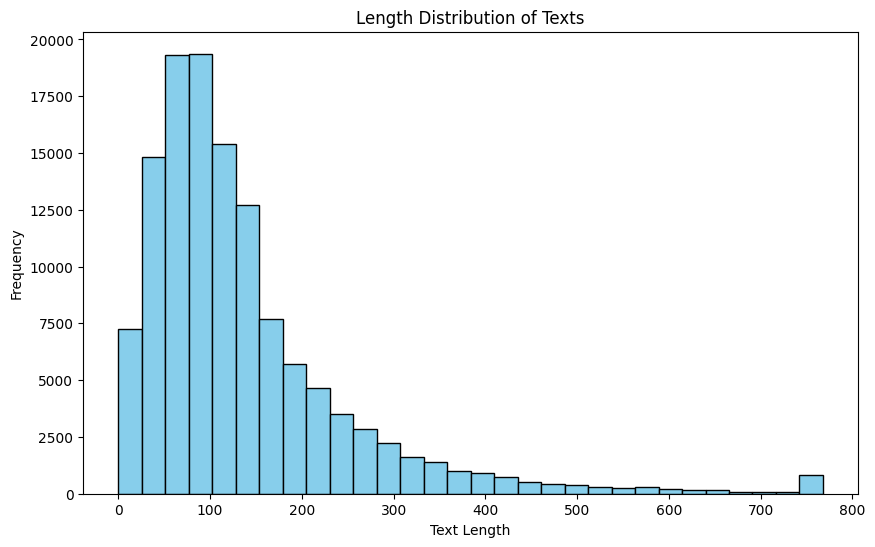

In [10]:
import matplotlib.pyplot as plt

df_exploded["length"] = df_exploded["text"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_exploded["length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Length Distribution of Texts")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Inference Modeling


|  Models |  Luxembourgish to English |  Luxembourgish to French | Luxembourgish to  German |
|:-------:|:-------:|:-------:|:-------:|
|  Mixtral 8*22B  |  Yes  |  Yes  |  Yes  |
|  Llama-3-4B  |  Yes  |  Yes  |  Yes  |
|  ChatGPT 3.5-Turbo |  Yes  |  Yes  |  Yes  |

In [ ]:
prompt_template = """Please translate the following {language_1} text into {language_2}. Please answer me with only translated text!

---------------------------------- Text to be translated ----------------------------------

{Text}

---------------------------------- Text to be translated ----------------------------------

"""

df_exploded["prompt"] = df_exploded["text"].apply( lambda text: prompt_template.format(language_1="Luxembourgish", language_2="English", Text=text))

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    pipeline,
)
from tqdm import tqdm
import pandas as pd
import argparse
import torch
import numpy as np
from datetime import datetime
import time

def initialize_pipeline(model_config_dict):
    model_path = model_config_dict["CURRENT_RUNNING_MODEL"]
    if not model_path:
        raise ValueError("CURRENT_RUNNING_MODEL is not set")
    load_in_4bit,load_in_8bit = model_config_dict["CURRENT_LOAD_IN_4BIT"],model_config_dict["CURRENT_LOAD_IN_8BIT"]

    if model_config_dict["IF_LOADING_QUANTIZATION"]:
        nf4_config = BitsAndBytesConfig(load_in_4bit=load_in_4bit, load_in_8bit=load_in_8bit,bnb_4bit_compute_dtype=torch.float16,)
    else:
        nf4_config = None

    generation_config = GenerationConfig.from_pretrained(model_path)
    # Sampling Methods Configuration
    generation_config.do_sample = True
    generation_config.max_length = 1024
    generation_config.pad_token_id = 0
    generation_config.top_p = 0.9
    generation_config.temperature = 0.9
    generation_config.max_new_tokens = 512
    dynamic_text_pipeline = pipeline("text-generation", model=model_path, torch_dtype=torch.float32, device_map="auto")
    dynamic_text_pipeline.model.generation_config = generation_config
    return dynamic_text_pipeline

def generate_text(pipeline, prompt):
    messages = [
        {"role": "system", "content": ""},
        {"role": "user", "content": prompt},
    ]
    response = pipeline(prompt)[0]["generated_text"][-1]
    return response


model_config_dict = {
    "CURRENT_RUNNING_MODEL": "mt_luxembourgish/meta-llama/Llama-3.2-3B-Instruct",
    "IF_LOADING_QUANTIZATION": False,
    "CURRENT_LOAD_IN_4BIT": False,
    "CURRENT_LOAD_IN_8BIT": False
}
pipeline = initialize_pipeline(model_config_dict)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Run inference
from datetime import datetime


pbar = tqdm(total=len(df_exploded))
pbar.n = 0; pbar.last_print_n =0, pbar.refresh()

current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
for index, row in df_exploded.iterrows():
        updated_row = row.copy()
        updated_row["generated_response"] = generate_text(pipeline=pipeline, prompt=updated_row["prompt"])
        updated_dataframe = pd.DataFrame([updated_row])
        if times == 0:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="w", header=True)
        else:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="a", header=False)
        pbar.update(1)
        times = times + 1